SoftMax Classification
================

------
**Deep Learning for Computer Vision**<br>
(c) Research Group CAMMA, University of Strasbourg<br>
Website: http://camma.u-strasbg.fr/
-----

### About this notebook

- **Objectives**: 
  - Hands-on practice on training a simple classifier with gradient descent
  - Use of toy datasets and MNIST
  - Visualization of classification boundaries
  

- **Intructions**:
  - To make the best use of this notebook, read the provided instructions and code, fill in the *#TODO* blocks, and run the code.

Import libraries:

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import pickle
import gzip

Function to generate a toy data distribution:

In [88]:
#%% Generate an (almost) linearly separable distribution

def toy_gaussian3(N=200):
  #N number of points per class
  D = 2   #dimensionality
  K = 3   #number of classes
  mean = [[-0.5, 0.5],[0.5, 0.5], [0, -0.5]]
  cov = [[0.1, 0], [0, 0.1]]
  X = np.zeros((N*K,D))
  y = np.zeros(N*K, dtype='uint8')
  for j in range(K):
    ix = range(N*j,N*(j+1))
    gx, gy = np.random.multivariate_normal(mean[j], cov, N).T
    X[ix] = np.vstack([gx,gy]).T
    y[ix] = j
  return X,y

Function to plot the toy data distribution:

In [89]:
def toy_plot(X,y):  
  fig = plt.figure()
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
  plt.xlim([-1.5,1.5])
  plt.ylim([-1.5,1.5])

Generate and plot data distribution:

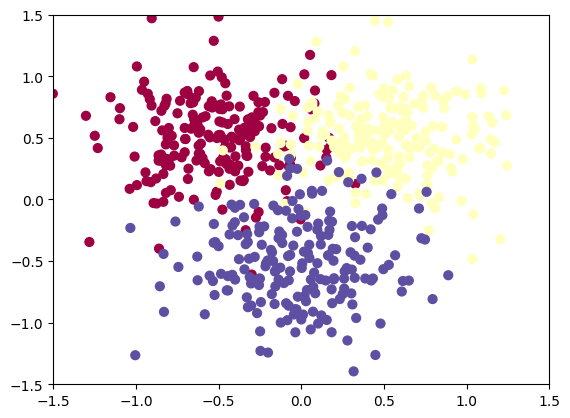

In [90]:
np.random.seed(999) #For reproducibility
[X,y] = toy_gaussian3(200)
toy_plot(X,y)

Define a simple prediction function that predicts the class as 0 if x<0 and as 1 if x>0:

In [91]:
def predict_simple(X):
    # Predict the classes for all input (X of size N*D, as for the toy data distribution)

    #TODO<
    N, _ = X.shape
    prediction = np.array([0 if X[i,0] < 0 else 1 for i in range(N)])
    return prediction
    #TODO>
    

The output of the code below should be [0,1,1]:

In [92]:
print( predict_simple(np.array([[-0.5,1],[0.5,1],[0.75,-1]])) )

[0 1 1]


The following function draws the decision boundary of a classifier *f* and overlays the training data X on the figure:

In [93]:
def plot_decision_boundaries(X,f):
 #Generate grid of data points 
 h = 0.01 #data step size
 x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
 y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
 xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

 #Predict class values for these data points                 
 Z = f(np.c_[xx.ravel(), yy.ravel()])
 Z = Z.reshape(xx.shape)

 #Plot the decisions nicely
 fig = plt.figure()
 plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
 plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
 plt.xlim(xx.min(), xx.max())
 plt.ylim(yy.min(), yy.max())

Visualize the decision boundary of our trivial classifier:

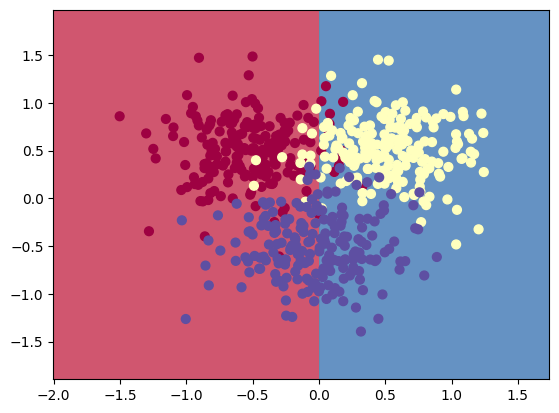

In [94]:
plot_decision_boundaries(X,predict_simple)

Define a function to predict the accuracy of the classifier:

In [95]:
def accuracy(f,X,y):
    #f is the classifier, X is the data and y is the ground truth
    
    #TODO<
    y_pred = f(X)
    accuracy = np.sum(y_pred == y) / y.shape[0]
    return accuracy
    #TODO>


Print the accuracy of our trivial classifier:

In [96]:
accuracy(predict_simple,X,y)

0.625

Define the prediction function for the classifier softmax, using the global variable sm_W and sm_b as parameters:

In [97]:
def predict_softmax(X):
    # Predict the classes for all input (X of size N*D)
    #TODO<
    y_pred = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        g = np.dot(x, sm_W) + sm_b # fonction discriminante
        sig = 1 / (1 + np.exp(-g))
        y_pred[i] = np.argmax(sig) # N.B : because we take argmax, and sig is an increasing function, we wouldn't even need to compute it and we could simply take np.argmax(g)
    return y_pred
    #TODO>

Let's define the missing parameters as follow:

In [98]:
sm_W = np.array( [[-3.51794922,  3.44784778,  0.06695316],
                 [ 2.1676949 ,  2.11218507, -4.3039451 ]] )

sm_b = np.array( [[-0.39265542, -0.36247215,  0.75512756]] )

Compute the accuracy (the result should be around 91%):

In [99]:
accuracy(predict_softmax,X,y)

0.91

Plot the decision boundary of this classifier:

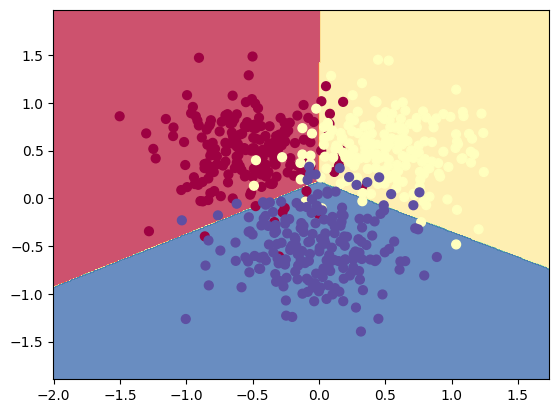

In [100]:
plot_decision_boundaries(X,predict_softmax)

Let's now use random parameters instead of the good parameters sm_W and sm_b that were initially provided:

In [101]:
sm_W = 0.01 * np.random.randn(2,3) #D*K
sm_b = np.zeros((1,3),dtype=np.float64) #1*K

Plot the accuracy of this classifier:

In [102]:
#TODO<
accuracy(predict_softmax,X,y)
#TODO>

0.545

Plot the respective decision boundary:

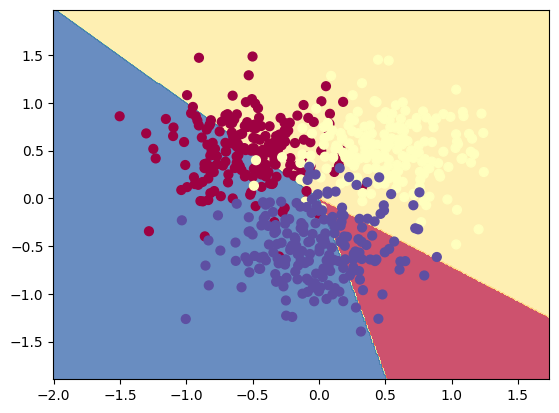

In [103]:
#TODO<
plot_decision_boundaries(X, predict_softmax)
#TODO>

What do you conclude? --> *random weights and bias leads to poor accuracy and results*

### How can we learn the parameters?

Let's learn W and b from the data using gradient descent:

In [104]:
# Train the classifier's parameters (using loop (index i) over all data points)
def train_softmax(X, y, ndims=2, nclasses=3, learning_rate=1e-0, reg_weight=1e-3, num_iters=200):
      #X of size N * D (N=number of data points, D=data dimension)
      #y of size N
      
      N = X.shape[0]  #number of data points
  
      #Initialize parameters randomly
      W = 0.01 * np.random.randn(ndims,nclasses) #D*K
      b = np.zeros((1,nclasses),dtype=np.float64) #1*K
 
     # Gradient descent 
      for t in range(0,num_iters) :
          
          #Variables to accumulate gradient
          dw = np.zeros(W.shape,dtype=np.float64) #D*K
          db = np.zeros(b.shape,dtype=np.float64) #1*K
          data_loss = 0.0
        
          #Pass over all data points
          for i in range(0,N):  #X is N*D
              Xi = X[i,:].reshape(1,ndims) #Xi is 1*D
              yi = y[i] #a number (class id)
              
              #forward pass (compute intermediate results and loss)
              scores  = np.dot(Xi,W) + b   #W is D*K
              expo = np.exp(scores) #expo is 1*K
              softm = expo / np.sum(expo)  #softm is 1*K
              lossi = -np.log(softm[0,yi])  #loss is a number: softmax value for True class       
              
              #backward pass (compute dw and db)
              #TODO<
              dscores = softm 
              dscores[0,yi] -= 1
              dw += Xi.T * dscores #Xi is 1*D and dsoftm is 1*K
              db += dscores
              #TODO>

              data_loss += lossi
              
          #Compute loss over all data    
          data_loss /= N  #Data loss (divide by number of data points)   
          reg_loss = 0.5*reg_weight*np.sum(W*W) #Regularization loss
          loss = data_loss + reg_loss
          
          #Finalize gradient computation
          dw /= N #Average over data points
          db /= N #Average over data points
          
          #TODO<
          dw += reg_weight * W  #add regularization gradient
          #TODO>
          
          #Gradient descent update
          W += -learning_rate * dw
          b += -learning_rate * db
          
          if t % 10 == 0: #Print loss every few steps
              print("iteration %d: loss %.4f " % (t, loss))
      
      return W,b

Let's try it out:

In [105]:
#%% Train a Linear Classifier and print accuracy

start_time = timeit.default_timer()

sm_W,sm_b = train_softmax(X,y)

end_time = timeit.default_timer()

acc = accuracy(predict_softmax,X,y)

print('\nTraining accuracy: %.2f  - time: %.2f' %(acc, end_time - start_time))

iteration 0: loss 1.1031 
iteration 10: loss 0.5205 
iteration 20: loss 0.3996 
iteration 30: loss 0.3509 
iteration 40: loss 0.3251 
iteration 50: loss 0.3094 
iteration 60: loss 0.2991 
iteration 70: loss 0.2918 
iteration 80: loss 0.2865 
iteration 90: loss 0.2826 
iteration 100: loss 0.2796 
iteration 110: loss 0.2772 
iteration 120: loss 0.2754 
iteration 130: loss 0.2739 
iteration 140: loss 0.2727 
iteration 150: loss 0.2717 
iteration 160: loss 0.2709 
iteration 170: loss 0.2702 
iteration 180: loss 0.2696 
iteration 190: loss 0.2691 

Training accuracy: 0.91  - time: 0.90


Plot the decision boundary of the trained classifier:

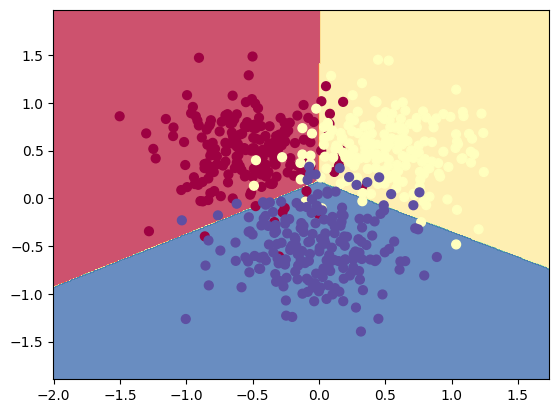

In [106]:
#TODO<
plot_decision_boundaries(X, predict_softmax)
#TODO>

Let's look at a more complex dataset:

In [107]:
#%% Generate a non linearly separable distribution

def toy_spiral3(N=200, K=3, D=2):
  np.random.seed(0)
  #N: number of points per class
  #D: dimensionality
  #K: number of classes
  X = np.zeros((N*K,D))
  y = np.zeros(N*K, dtype='uint8')
  for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = 5 + np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.3 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
  return X,y

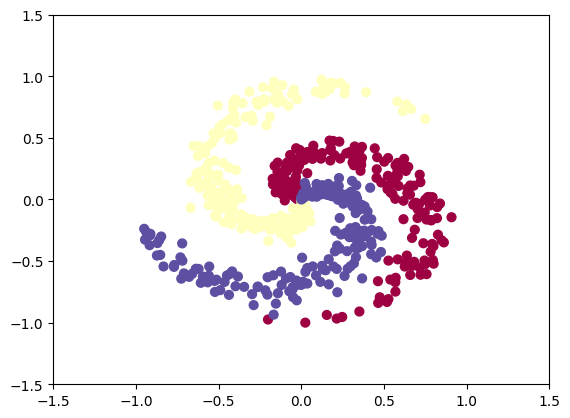

In [108]:
np.random.seed(999) #For reproducibility
[X,y] = toy_spiral3(200)
toy_plot(X,y)

Train the softmax classifier on this dataset and print accuracy:

In [109]:
#TODO<
start_time = timeit.default_timer()

sm_W,sm_b = train_softmax(X,y)

end_time = timeit.default_timer()

acc = accuracy(predict_softmax,X,y)

print('\nTraining accuracy: %.2f  - time: %.2f' %(acc, end_time - start_time))
#TODO>

iteration 0: loss 1.1008 
iteration 10: loss 0.9097 
iteration 20: loss 0.8403 
iteration 30: loss 0.8096 
iteration 40: loss 0.7942 
iteration 50: loss 0.7856 
iteration 60: loss 0.7806 
iteration 70: loss 0.7775 
iteration 80: loss 0.7756 
iteration 90: loss 0.7743 
iteration 100: loss 0.7735 
iteration 110: loss 0.7729 
iteration 120: loss 0.7726 
iteration 130: loss 0.7723 
iteration 140: loss 0.7721 
iteration 150: loss 0.7720 
iteration 160: loss 0.7719 
iteration 170: loss 0.7718 
iteration 180: loss 0.7718 
iteration 190: loss 0.7718 

Training accuracy: 0.53  - time: 0.92


Plot the decision boundary of the trained classifier:

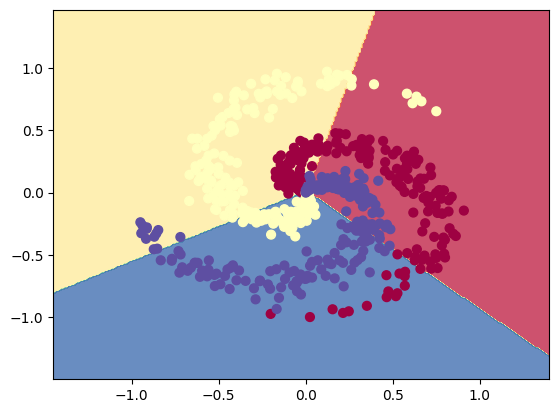

In [110]:
#TODO<
plot_decision_boundaries(X, predict_softmax)
#TODO>

What do you conclude? --> *softmax (perceptron) suppose que les classes sont linéairements séparables, ce qui n'est pas le cas ici, d'où les résultats médiocres.*

### Bonus 1

Try on MNIST

In [111]:
#Download the dataset if needed:
if 1:
  import urllib
  urllib.request.urlretrieve('https://seafile.unistra.fr/f/ea3445be9fa3473e8408/?dl=1','mnist.pkl.gz')

In [112]:
path = './' #TO ADAPT IF NEEDED
f = gzip.open(path+'mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f,encoding='bytes')
f.close()

In [113]:
#%% Shuffle the data and define the data variables
X_train,y_train = train_set
X_test,y_test = test_set

inds=np.arange(0,X_train.shape[0])
np.random.shuffle(inds)
X_train,y_train = X_train[inds],y_train[inds] 

inds=np.arange(0,X_test.shape[0])
np.random.shuffle(inds)
X_test,y_test = X_test[inds],y_test[inds] 

Print the size of the dataset:

In [114]:
print(X_train.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)


Visualize one image (of dimension 28x28) and its label:

6


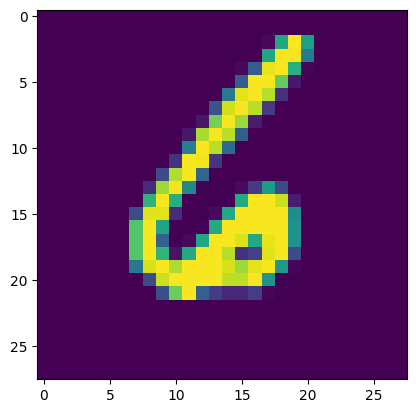

In [115]:
i = X_train[6,:]
plt.imshow(i.reshape(28,28))
print(y_train[6])

Train the sofmax classifier on this dataset:

In [116]:
#TODO<
sm_W, sm_b = train_softmax(X_train, y_train, ndims=784, nclasses=10)
#TODO>

iteration 0: loss 2.3034 
iteration 10: loss 0.7293 
iteration 20: loss 0.6241 
iteration 30: loss 0.4617 
iteration 40: loss 0.4289 
iteration 50: loss 0.4145 
iteration 60: loss 0.4041 
iteration 70: loss 0.3961 
iteration 80: loss 0.3897 
iteration 90: loss 0.3845 
iteration 100: loss 0.3801 
iteration 110: loss 0.3764 
iteration 120: loss 0.3732 
iteration 130: loss 0.3704 
iteration 140: loss 0.3680 
iteration 150: loss 0.3658 
iteration 160: loss 0.3639 
iteration 170: loss 0.3622 
iteration 180: loss 0.3607 
iteration 190: loss 0.3593 


Print the training accuracy:

In [117]:
#TODO<
print('\nTraining accuracy: %.2f' %(accuracy(predict_softmax,X_train,y_train)) )
#TODO>


Training accuracy: 0.91


Print the accuracy on the test set:

In [118]:
#TODO<
print('\nTesting accuracy: %.2f' %(accuracy(predict_softmax,X_test,y_test)) )
#TODO>


Testing accuracy: 0.92


### Bonus 2

Improve the training function by using vectorization, namely remove the loop over all data points in the previous code:

In [119]:
# Train the classifier's parameters (using loop (index i) over data points)
def train_softmax_vectorized(X, y, ndims=2, nclasses=3, learning_rate=1e-0, reg_weight=1e-3, num_iters=200):
      #X of size N * D (N=number of data points, D=data dimension)
      #y of size N

      N = X.shape[0]  #number of data points
  
      #Initialize parameters randomly
      W = 0.01 * np.random.randn(ndims,nclasses) #D*K
      b = np.zeros((1,nclasses),dtype=np.float64) #1*K
 
      #Gradient descent 
      for t in range(0,num_iters) :
          
          #forward pass (for all data points)
          scores  = np.dot(X,W) + b   #X is N*D and W is D*K and b is 1*K (broadcasted)
          expo = np.exp(scores) #expo is N*K
          softm = expo / np.sum(expo,axis=1,keepdims=True)  #softm is N*K
          logs = -np.log(softm[range(N),y])  #size N (get values for True class)
              
          #TODO<
          #compute loss
          data_loss = np.sum(logs) / N
          reg_loss = 0.5*reg_weight*np.sum(W*W) #Regularization loss
          loss = data_loss + reg_loss
          
          #backward pass 
          dscores = softm  #N*K
          dscores[range(N),y] -= 1
          dw = np.dot(X.T,dscores) / N #D*K
          db = np.sum(dscores,axis=0, keepdims=True) / N #1*K
          
          #add regularization gradient
          dw += reg_weight * W  
            
          #TODO>

          #Gradient update
          W += -learning_rate * dw
          b += -learning_rate * db
          
          if t % 10 == 0: #Print loss every few steps
              print("iteration %d: loss %.4f" % (t, loss))
      
      return W,b

Train the classifier and print training accuracy on toy dataset:

In [120]:
#TODO<
start_time = timeit.default_timer()

sm_W,sm_b = train_softmax_vectorized(X,y)

end_time = timeit.default_timer()

acc = accuracy(predict_softmax,X,y)

print('\nTraining accuracy: %.2f  - time: %.2f' %(acc, end_time - start_time))
#TODO>

iteration 0: loss 1.0977
iteration 10: loss 0.9087
iteration 20: loss 0.8398
iteration 30: loss 0.8094
iteration 40: loss 0.7941
iteration 50: loss 0.7856
iteration 60: loss 0.7806
iteration 70: loss 0.7775
iteration 80: loss 0.7756
iteration 90: loss 0.7743
iteration 100: loss 0.7735
iteration 110: loss 0.7729
iteration 120: loss 0.7726
iteration 130: loss 0.7723
iteration 140: loss 0.7721
iteration 150: loss 0.7720
iteration 160: loss 0.7719
iteration 170: loss 0.7718
iteration 180: loss 0.7718
iteration 190: loss 0.7718

Training accuracy: 0.53  - time: 0.03


Train the softmax classifier and print accuracy on MNIST:

In [121]:
#TODO<
start_time = timeit.default_timer()

sm_W,sm_b = train_softmax_vectorized(X_train,y_train,nclasses=10,ndims=784)

end_time = timeit.default_timer()

acc = accuracy(predict_softmax,X_test,y_test)

print('\nTraining accuracy: %.2f  - time: %.2f' %(acc, end_time - start_time))
#TODO>

iteration 0: loss 2.2927
iteration 10: loss 0.7519
iteration 20: loss 0.6151
iteration 30: loss 0.4631
iteration 40: loss 0.4302
iteration 50: loss 0.4149
iteration 60: loss 0.4041
iteration 70: loss 0.3960
iteration 80: loss 0.3897
iteration 90: loss 0.3845
iteration 100: loss 0.3801
iteration 110: loss 0.3764
iteration 120: loss 0.3732
iteration 130: loss 0.3705
iteration 140: loss 0.3680
iteration 150: loss 0.3659
iteration 160: loss 0.3640
iteration 170: loss 0.3623
iteration 180: loss 0.3607
iteration 190: loss 0.3593

Training accuracy: 0.92  - time: 45.79


---------------

### THE END

---------------